In [1]:
%run load_base_runs.ipynb

In [2]:
import pandas
%load_ext autoreload

%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from mlflow import MlflowClient
import mlflow
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import collections
import matplotlib as mpl
import numpy as np
from collections import defaultdict
import scienceplots
from sklearn import datasets
from sklearn.datasets import make_blobs
from cycler import cycler
from pathlib import Path
import ast

plt.style.use(['science', 'bright'])


In [4]:
QUAD_SPLIT_PARAMS = ['metrics.no_of_predicates_median', 'metrics.complex_clfs',
                     'metrics.rules', 'metrics.no_of_predicates_max',
                     'metrics.dummy_clfs', 'metrics.no_of_predicates_min',
                     'metrics.all_clfs', 'params.min_split_percentage',
                    'params.complexity_measure',
                     'params.base_clf','params.min_samples']

In [5]:
if cached("06.07-quadsplit-3"):
    quad_split_runs_df = load_cache("06.07-quadsplit-3")
else:
    quad_split_runs_df =get_runs_for("06.07-quadsplit-3")\
        .assign(cls_report=lambda row: row['artifact_uri'].apply(lambda v: get_metrics(v, "cls_report.json")))\
        .assign(imb_cls_report=lambda row: row['artifact_uri'].apply(lambda v: get_metrics(v, "imb_cls_report.json")))\
        .assign(qs_complexity=lambda row: row['artifact_uri'].apply(lambda v: get_metrics(v, "quad_split.json")))\
        [CLASSIFICATION_METRICS + DATASET_PARAMS + QUAD_SPLIT_PARAMS + ["qs_complexity"]] \
        .assign(**classification_metrics_extractors)

In [6]:
cache(quad_split_runs_df, "06.07-quadsplit-3")

In [7]:
base_runs_rf.rename(columns={c: c+'_rf' for c in base_runs_rf.columns if 'metric' in c or 'test_' in c}, inplace=True)
base_runs_dt.rename(columns={c: c+'_dt' for c in base_runs_dt.columns if 'metric' in c  or 'test_' in c}, inplace=True)
base_runs_greedy.rename(columns={c: c+'_greedy' for c in base_runs_greedy.columns if 'metric' in c or 'test_' in c}, inplace=True)
base_runs_oner.rename(columns={c: c+'_oner' for c in base_runs_oner.columns if 'metric' in c or 'test_' in c}, inplace=True)
base_runs_rulefit.rename(columns={c: c+'_rulefit' for c in base_runs_rulefit.columns if 'metric' in c or 'test_' in c}, inplace=True)


In [8]:
base_runs_together_df = pd.merge(
    base_runs_dt,
    base_runs_rf,
    how='right',
    on=DATASET_PARAMS,
    suffixes=('_dt', '_rf')
)\
    .merge(base_runs_greedy, how='right', on=DATASET_PARAMS, suffixes=('', '_greedy'))\
    .merge(base_runs_oner, how='right', on=DATASET_PARAMS, suffixes=('', '_oner'))\
    .merge(base_runs_rulefit, how='right', on=DATASET_PARAMS, suffixes=('', '_rulefit'))\
    .dropna()
quad_split_df = pd.merge(
    base_runs_together_df,
    quad_split_runs_df,
    how='right',
    on=DATASET_PARAMS,
    suffixes=('', '_opt')
)
quad_split_df = pd.merge(
    quad_split_df,
    complexities_df,
    how='left',
    on=DATASET_PARAMS
)

In [9]:
LABELS_THAT_SHOULD_BE =["better", "equal", "worse"] 

In [10]:
quad_split_df.dropna(inplace=True)

In [11]:
LIMITING_QUERY = "`params.min_samples` == '28' and `params.min_split_percentage` == '0.183'"

In [12]:
METRICS = list(classification_metrics_extractors.keys())
METRICS

['test_index_balanced_accuracy',
 'test_geometric_mean',
 'test_f1',
 'test_specificity',
 'test_recall',
 'test_precision',
 'test_balanced_accuracy',
 'test_accuracy']

In [13]:
SUFFIXES = ["_dt", "_rf", "_oner", "_rulefit", "_greedy"]

In [14]:
def define_comparison(row, suffix, metric):
    if row[f'{metric}_equal{suffix}']:
        return "equal"
    if row[f'{metric}_better{suffix}']:
        return "better"
    else:
        return "worse"

def define_comparison_complexity(row, suffix, metric):
    if row[f'{metric}_equal{suffix}']:
        return "equal"
    if row[f'{metric}_better{suffix}']:
        return "bigger"
    else:
        return "smaller"

In [15]:
for suffix in SUFFIXES:
    for metric in METRICS:
        quad_split_df[f'{metric}_diff_to{suffix}'] = quad_split_df[metric] - quad_split_df[f'{metric}{suffix}']
        quad_split_df[f'{metric}_better_equal{suffix}'] = quad_split_df[metric] >= quad_split_df[f'{metric}{suffix}']
        quad_split_df[f'{metric}_better{suffix}'] = quad_split_df[metric] > quad_split_df[f'{metric}{suffix}']
        quad_split_df[f'{metric}_worse{suffix}'] = ~quad_split_df[f'{metric}_better_equal{suffix}']
        quad_split_df[f'{metric}_worse_equal{suffix}'] = ~quad_split_df[f'{metric}_better{suffix}']
        quad_split_df[f'{metric}_equal{suffix}'] = quad_split_df[metric] == quad_split_df[f'{metric}{suffix}']
        quad_split_df[f'{metric}_comparison{suffix}'] = quad_split_df.apply(lambda row: define_comparison(row, suffix, metric), axis=1)

/var/folders/fd/dyfc8ph167q7r5pf9y8451540000gn/T/ipykernel_16707/3550015072.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  quad_split_df[f'{metric}_comparison{suffix}'] = quad_split_df.apply(lambda row: define_comparison(row, suffix, metric), axis=1)
/var/folders/fd/dyfc8ph167q7r5pf9y8451540000gn/T/ipykernel_16707/3550015072.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  quad_split_df[f'{metric}_diff_to{suffix}'] = quad_split_df[metric] - quad_split_df[f'{metric}{suffix}']
/var/folders/fd/dyfc8ph167q7r5pf9y8451540000gn

In [17]:
quad_split_df.query('`params.base_clf` == "dt"')

,cls_report_dt,imb_cls_report_dt,params.should_take_test,params.dataset,params.data_shuffle_random_state,metrics.depth_dt,metrics.n_leaves_dt,test_index_balanced_accuracy_dt,test_geometric_mean_dt,test_f1_dt,...,test_balanced_accuracy_worse_equal_greedy,test_balanced_accuracy_equal_greedy,test_balanced_accuracy_comparison_greedy,test_accuracy_diff_to_greedy,test_accuracy_better_equal_greedy,test_accuracy_better_greedy,test_accuracy_worse_greedy,test_accuracy_worse_equal_greedy,test_accuracy_equal_greedy,test_accuracy_comparison_greedy
960,"{'0': {'precision': 0.9655172413793104, 'recal...","{'0': {'pre': 0.9655172413793104, 'rec': 0.782...",False,crx,99,2.0,3.0,0.754381,0.869310,0.865315,...,True,False,worse,-0.076453,False,False,True,True,False,worse
961,"{'0': {'precision': 0.9182389937106918, 'recal...","{'0': {'pre': 0.9182389937106918, 'rec': 0.820...",True,crx,99,2.0,3.0,0.747545,0.864973,0.862235,...,True,False,worse,-0.046012,False,False,True,True,False,worse
962,"{'0': {'precision': 0.7758620689655172, 'recal...","{'0': {'pre': 0.7758620689655172, 'rec': 0.918...",False,breast,99,3.0,5.0,0.343601,0.579645,0.731285,...,True,False,worse,-0.057554,False,False,True,True,False,worse
963,"{'0': {'precision': 0.8055555555555556, 'recal...","{'0': {'pre': 0.8055555555555556, 'rec': 0.887...",True,breast,99,6.0,8.0,0.428999,0.649372,0.757181,...,True,False,worse,-0.065217,False,False,True,True,False,worse
964,"{'0': {'precision': 0.9024390243902439, 'recal...","{'0': {'pre': 0.9024390243902439, 'rec': 0.880...",False,appendicitis,99,5.0,9.0,0.568626,0.748736,0.832857,...,True,False,worse,-0.132075,False,False,True,True,False,worse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,"{'0': {'precision': 0.4142857142857143, 'recal...","{'0': {'pre': 0.4142857142857143, 'rec': 0.432...",True,bands,42,8.0,19.0,0.280068,0.527750,0.567818,...,False,False,better,-0.021978,False,False,True,True,False,worse
1916,"{'0': {'precision': 0.4915254237288136, 'recal...","{'0': {'pre': 0.4915254237288136, 'rec': 0.397...",False,bupa,42,8.0,15.0,0.279396,0.527335,0.563563,...,False,False,better,0.005780,True,True,False,False,False,better
1917,"{'0': {'precision': 0.5, 'recall': 0.638888888...","{'0': {'pre': 0.5, 'rec': 0.6388888888888888, ...",True,bupa,42,7.0,16.0,0.344445,0.587367,0.583664,...,False,False,better,-0.011628,False,False,True,True,False,worse
1918,"{'0': {'precision': 0.9459459459459459, 'recal...","{'0': {'pre': 0.9459459459459459, 'rec': 0.945...",False,wisconsin,42,2.0,3.0,0.852518,0.922687,0.929825,...,True,False,worse,0.017544,True,True,False,False,False,better


In [72]:
def calculate_qs_complexity(vals):
    sum_of_predicates = sum(vals['rules'])
    rules_count = len(vals['rules'])

    basic_metrics = {
        "dummy_clfs": vals['dummy_clfs'],
        "complex_clfs": vals['complex_clfs'],
        "sum_of_predicates": sum_of_predicates,
        "rules_count": rules_count
    }
    
    if vals['dts']:
        dts = sum([int(d['n_leaves']) for d in vals['dts']])
        return {
        **basic_metrics,
        "complexity": dts + rules_count,
        }

    return basic_metrics

In [19]:
quad_split_df = quad_split_df.join(quad_split_df['qs_complexity'].apply(calculate_qs_complexity).apply(pd.Series))

In [20]:
for suffix in SUFFIXES:
    for metric in ["complexity"]:
        quad_split_df[f'{metric}_diff_to{suffix}'] = quad_split_df[metric] - quad_split_df[f'{metric}{suffix}']
        quad_split_df[f'{metric}_better_equal{suffix}'] = quad_split_df[metric] >= quad_split_df[f'{metric}{suffix}']
        quad_split_df[f'{metric}_better{suffix}'] = quad_split_df[metric] > quad_split_df[f'{metric}{suffix}']
        quad_split_df[f'{metric}_worse{suffix}'] = ~quad_split_df[f'{metric}_better_equal{suffix}']
        quad_split_df[f'{metric}_worse_equal{suffix}'] = ~quad_split_df[f'{metric}_better{suffix}']
        quad_split_df[f'{metric}_equal{suffix}'] = quad_split_df[metric] == quad_split_df[f'{metric}{suffix}']
        quad_split_df[f'{metric}_comparison{suffix}'] = quad_split_df.apply(lambda row: define_comparison_complexity(row, suffix, metric), axis=1)

/var/folders/fd/dyfc8ph167q7r5pf9y8451540000gn/T/ipykernel_16707/1101448468.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  quad_split_df[f'{metric}_diff_to{suffix}'] = quad_split_df[metric] - quad_split_df[f'{metric}{suffix}']
/var/folders/fd/dyfc8ph167q7r5pf9y8451540000gn/T/ipykernel_16707/1101448468.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  quad_split_df[f'{metric}_better_equal{suffix}'] = quad_split_df[metric] >= quad_split_df[f'{metric}{suffix}']
/var/folders/fd/dyfc8ph167q7r5pf9y8451540000gn/T/ipykernel_16707

In [21]:
for metric in COMPLEXITY_METRICS:
    quad_split_df[f'{metric}-discretized'] = pd.qcut(quad_split_df[metric], 3, labels=["low", "medium", "high"])


/var/folders/fd/dyfc8ph167q7r5pf9y8451540000gn/T/ipykernel_16707/316881999.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  quad_split_df[f'{metric}-discretized'] = pd.qcut(quad_split_df[metric], 3, labels=["low", "medium", "high"])
/var/folders/fd/dyfc8ph167q7r5pf9y8451540000gn/T/ipykernel_16707/316881999.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  quad_split_df[f'{metric}-discretized'] = pd.qcut(quad_split_df[metric], 3, labels=["low", "medium", "high"])
/var/folders/fd/dyfc8ph167q7r5pf9y8451540000gn/T/ipykernel_167

In [22]:
ALL_DISCRETIZED_METRICS = [f'{metric}-discretized' for metric in COMPLEXITY_METRICS]

In [23]:
compare_values = {
    "low": 0,
    "medium": 1,
    "high": 2,
}
compare_values_inverted = {
    v: k for k, v in compare_values.items()
}
def take_higher(row):
    vals = [compare_values[it] for it in [row[0], row[1]]]
    max_val = max(vals)
    
    return compare_values_inverted[max_val]

In [24]:
quad_split_df['overall-complexity'] = quad_split_df[ALL_DISCRETIZED_METRICS].mode(axis=1).fillna('low').apply(take_higher, axis=1)

/var/folders/fd/dyfc8ph167q7r5pf9y8451540000gn/T/ipykernel_16707/2910056351.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  quad_split_df['overall-complexity'] = quad_split_df[ALL_DISCRETIZED_METRICS].mode(axis=1).fillna('low').apply(take_higher, axis=1)


# COMPARISON TO ALGORITHSM

In [25]:
quad_split_df.query(LIMITING_QUERY)


,cls_report_dt,imb_cls_report_dt,params.should_take_test,params.dataset,params.data_shuffle_random_state,metrics.depth_dt,metrics.n_leaves_dt,test_index_balanced_accuracy_dt,test_geometric_mean_dt,test_f1_dt,...,n4-discretized,t1-discretized,t2-discretized,t3-discretized,t4-discretized,clsCoef-discretized,hubs-discretized,density-discretized,lsc-discretized,overall-complexity
0,"{'0': {'precision': 0.9655172413793104, 'recal...","{'0': {'pre': 0.9655172413793104, 'rec': 0.782...",False,crx,99,2.0,3.0,0.754381,0.869310,0.865315,...,high,medium,medium,low,low,medium,high,high,high,high
1,"{'0': {'precision': 0.9182389937106918, 'recal...","{'0': {'pre': 0.9182389937106918, 'rec': 0.820...",True,crx,99,2.0,3.0,0.747545,0.864973,0.862235,...,high,high,medium,low,low,medium,high,medium,high,high
2,"{'0': {'precision': 0.7758620689655172, 'recal...","{'0': {'pre': 0.7758620689655172, 'rec': 0.918...",False,breast,99,3.0,5.0,0.343601,0.579645,0.731285,...,medium,medium,medium,medium,medium,high,medium,medium,medium,medium
3,"{'0': {'precision': 0.8055555555555556, 'recal...","{'0': {'pre': 0.8055555555555556, 'rec': 0.887...",True,breast,99,6.0,8.0,0.428999,0.649372,0.757181,...,medium,medium,medium,medium,medium,high,medium,medium,medium,medium
4,"{'0': {'precision': 0.9024390243902439, 'recal...","{'0': {'pre': 0.9024390243902439, 'rec': 0.880...",False,appendicitis,99,5.0,9.0,0.568626,0.748736,0.832857,...,low,low,high,high,medium,low,low,low,low,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,"{'0': {'precision': 0.4142857142857143, 'recal...","{'0': {'pre': 0.4142857142857143, 'rec': 0.432...",True,bands,42,8.0,19.0,0.280068,0.527750,0.567818,...,high,high,high,high,medium,medium,medium,medium,high,high
2876,"{'0': {'precision': 0.4915254237288136, 'recal...","{'0': {'pre': 0.4915254237288136, 'rec': 0.397...",False,bupa,42,8.0,15.0,0.279396,0.527335,0.563563,...,high,high,medium,medium,medium,low,low,low,medium,high
2877,"{'0': {'precision': 0.5, 'recall': 0.638888888...","{'0': {'pre': 0.5, 'rec': 0.6388888888888888, ...",True,bupa,42,7.0,16.0,0.344445,0.587367,0.583664,...,high,high,low,medium,medium,low,low,low,high,high
2878,"{'0': {'precision': 0.9459459459459459, 'recal...","{'0': {'pre': 0.9459459459459459, 'rec': 0.945...",False,wisconsin,42,2.0,3.0,0.852518,0.922687,0.929825,...,low,low,low,medium,high,low,low,low,low,low


In [26]:
METRICS_TO_CONSIDER = ["test_balanced_accuracy", "test_f1", "test_geometric_mean"]
METRIC_LABELS = ["BalAcc", "F1", "GMean"]

In [27]:
quad_split_df.groupby(["params.complexity_measure"])[METRICS_TO_CONSIDER].mean()

,test_balanced_accuracy,test_f1,test_geometric_mean
params.complexity_measure,,,
c1,0.703513,0.743943,0.681536
density,0.711953,0.751197,0.691216
f2,0.710228,0.749691,0.688220
l2,0.711571,0.751252,0.688776
n3,0.709703,0.749057,0.688821
t4,0.709020,0.748903,0.686685


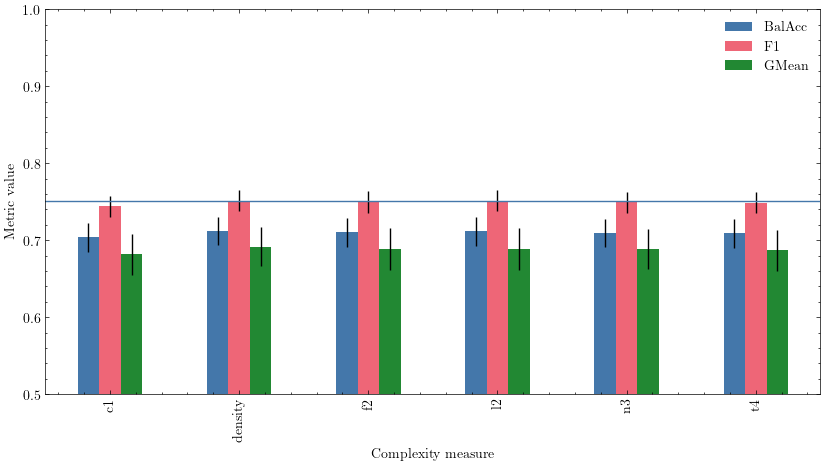

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

err_vars = quad_split_df.groupby(["params.complexity_measure"])[METRICS_TO_CONSIDER].var()

df_to_plot = quad_split_df.groupby(["params.complexity_measure"])[METRICS_TO_CONSIDER].mean()

df_to_plot.plot(kind='bar', ax=ax, yerr=err_vars)

ax.set_ylim(0.5, 1)

ax.legend(METRIC_LABELS)
ax.set_xlabel("Complexity measure")
ax.set_ylabel("Metric value")
ax.axhline(df_to_plot['test_f1'].max())
# for container in ax.containers:
#     ax.bar_label(container)
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='center right')
fig.savefig('../figures/quad/complexity-metric-comparison.pdf')

In [29]:
quad_split_df.groupby(["params.base_clf"])[METRICS_TO_CONSIDER].mean()

,test_balanced_accuracy,test_f1,test_geometric_mean
params.base_clf,,,
dt,0.724763,0.759291,0.712321
knn,0.712363,0.759542,0.676902
svm,0.690869,0.728189,0.673403


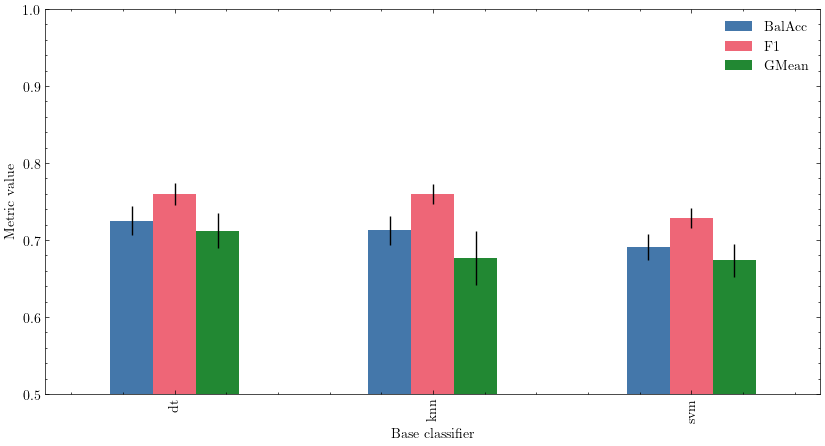

In [30]:
fix, ax = plt.subplots(1, 1, figsize=(10, 5))

err_vars = quad_split_df.groupby(["params.base_clf"])[METRICS_TO_CONSIDER].var()
quad_split_df.groupby(["params.base_clf"])[METRICS_TO_CONSIDER].mean().plot(kind='bar', ax=ax, yerr=err_vars)

ax.set_ylim(0.5, 1)


ax.set_xlabel("Base classifier")
ax.set_ylabel("Metric value")
ax.legend(METRIC_LABELS)


In [31]:
LIMITING_QUERY = "`params.min_samples` == '28' and `params.min_split_percentage` == '0.183' and `params.base_clf` == 'dt' and `params.complexity_measure` == 'density'"

In [32]:
def vals_to_percentage(l):
    total = sum(l)
    
    return [round(item/total*100,2) for item in l]
    

## WINS-LOSSES acc general

In [33]:
def make_sure_all_labels_are_there(df):
    missing_labels = set(LABELS_THAT_SHOULD_BE) - set(df.index)

    for label in missing_labels:
        df.loc[label] = pd.Series()

    return df.reindex(LABELS_THAT_SHOULD_BE)

In [34]:
def plot_bar(labels, values_dict, quants, ax):
    plot_labels = [l.split('_')[-1].upper() for l in labels]
    data = np.array(list(values_dict.values()))
    data_cum = data.cumsum(axis=1)
        
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, colname in enumerate(quants):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(plot_labels, widths, left=starts, height=0.5, label=colname)

        ax.bar_label(rects, label_type='center')




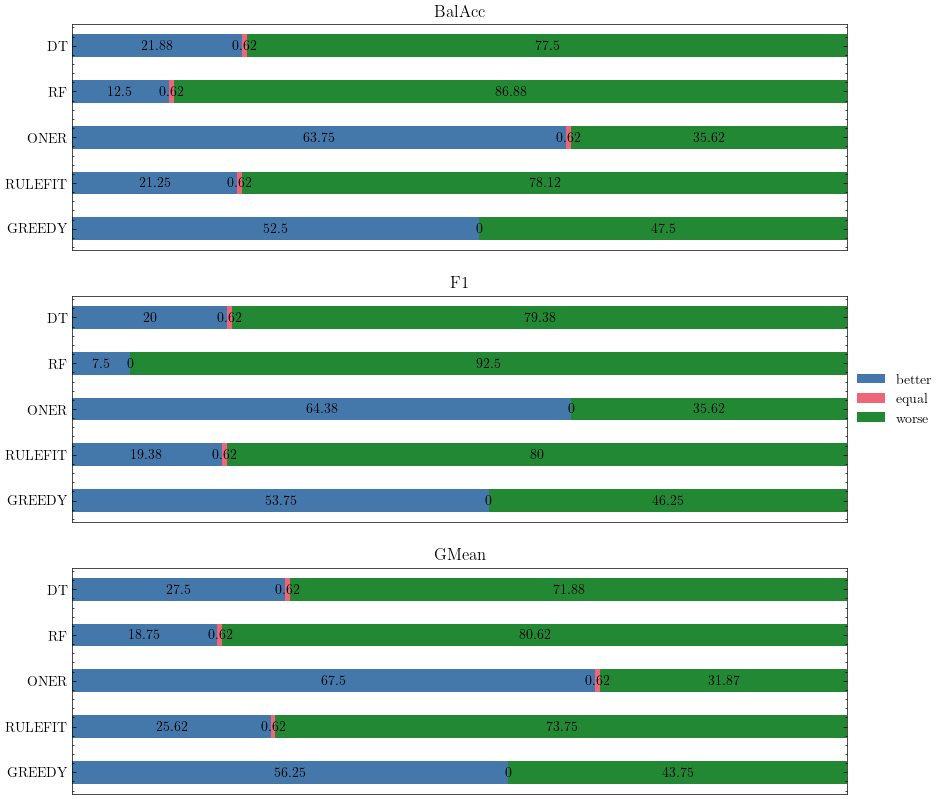

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 10))


ax1.set_title("BalAcc")
labels = [f"test_balanced_accuracy_comparison{suffix}" for suffix in SUFFIXES]
vals_to_plot = {k: vals_to_percentage(v.values()) for k,v in make_sure_all_labels_are_there(quad_split_df.query(LIMITING_QUERY)[labels].apply(pd.Series.value_counts)).fillna(0).reindex(LABELS_THAT_SHOULD_BE).to_dict().items()}
plot_bar(labels, vals_to_plot, ['better', 'equal', 'worse'], ax1)

ax2.set_title("F1")
labels = [f"test_f1_comparison{suffix}" for suffix in SUFFIXES]
vals_to_plot = {k: vals_to_percentage(v.values()) for k,v in make_sure_all_labels_are_there(quad_split_df.query(LIMITING_QUERY)[labels].apply(pd.Series.value_counts)).fillna(0).reindex(LABELS_THAT_SHOULD_BE).to_dict().items()}
plot_bar(labels, vals_to_plot, ['better', 'equal', 'worse'], ax2)


ax3.set_title("GMean")
labels = [f"test_geometric_mean_comparison{suffix}" for suffix in SUFFIXES]
vals_to_plot = {k: vals_to_percentage(v.values()) for k,v in make_sure_all_labels_are_there(quad_split_df.query(LIMITING_QUERY)[labels].apply(pd.Series.value_counts)).fillna(0).reindex(LABELS_THAT_SHOULD_BE).to_dict().items()}
plot_bar(labels, vals_to_plot, ['better', 'equal', 'worse'], ax3)

handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')

fig.savefig('../figures/quad/overall-performance-barplot.pdf')

In [36]:
ACC_LABELS = [f"test_balanced_accuracy_comparison{suffix}" for suffix in SUFFIXES]
F1_LABELS = [f"test_f1_comparison{suffix}" for suffix in SUFFIXES]
GMEAN_LABELS = [f"test_geometric_mean_comparison{suffix}" for suffix in SUFFIXES]

In [37]:
COMPLEXITIES_TO_CONSIDER = ['f2', 't4', 'c1', 'n3', 'l2', 'density']

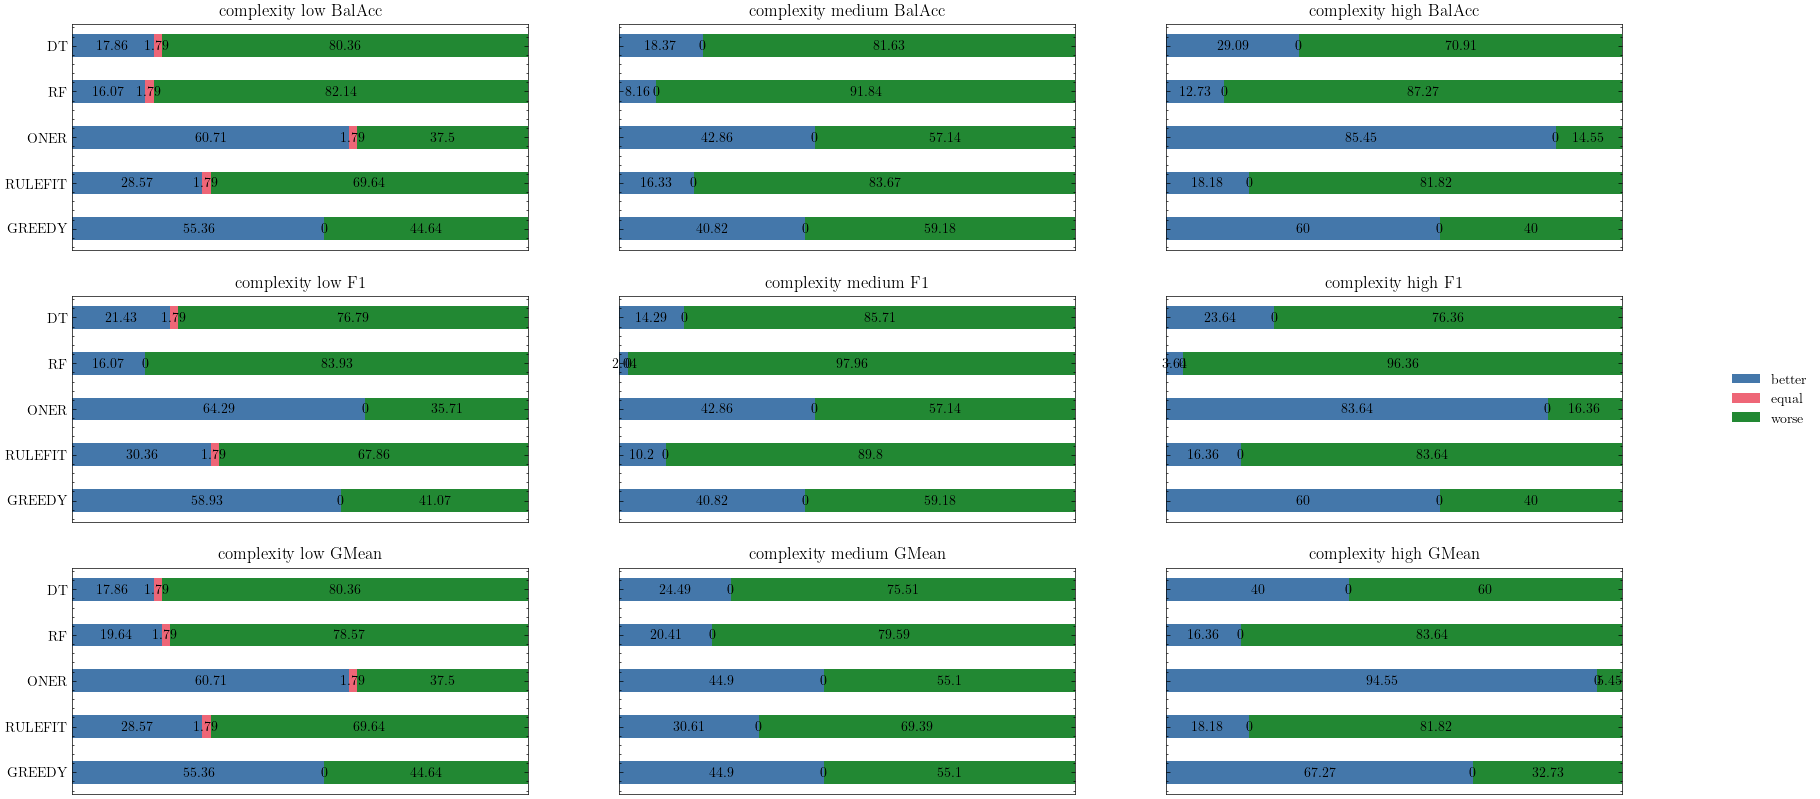

In [38]:
fig, axes = plt.subplots(3,3, sharey=True, figsize=(20, 10))

axes = axes.reshape(-1)

axes_iter = iter(axes)
plot_labels = [l.split('_')[-1].upper() for l in ACC_LABELS]



for labels, label in zip([ACC_LABELS, F1_LABELS, GMEAN_LABELS], METRIC_LABELS):
    for value in ['low', 'medium', 'high']:
        ax = next(axes_iter)
        vals_to_plot = {k: vals_to_percentage(v.values()) for k,v in make_sure_all_labels_are_there(quad_split_df.query(LIMITING_QUERY).query(f"`overall-complexity` == '{value}'")[labels].apply(pd.Series.value_counts)).fillna(0).to_dict().items()}
    
        data = np.array(list(vals_to_plot.values()))
        data_cum = data.cumsum(axis=1)
        ax.invert_yaxis()
        ax.xaxis.set_visible(False)
        # ax.yaxis.set_visible(False)
        ax.set_xlim(0, np.sum(data, axis=1).max())

        for i, colname in enumerate(['better', 'equal', 'worse']):
            widths = data[:, i]
            starts = data_cum[:, i] - widths
            rects = ax.barh(plot_labels, widths, left=starts, height=0.5, label=colname)
            ax.bar_label(rects, label_type='center')
    
        ax.set_title(f"complexity {value} {label}")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.savefig("../figures/quad/overall-complexity-barplot.pdf")

In [39]:
def get_weighted_variances_merics(metric):
    variances = quad_split_df\
    .query(LIMITING_QUERY) \
    [[metric] + ALL_DISCRETIZED_METRICS] \
    .melt(metric)\
    .groupby(['variable', 'value'], as_index=False).apply(lambda x: np.sum(x)/len(x))\
    .groupby('variable')[metric].var()
    
    weighted_variances = variances.apply(lambda it: it/variances.sum())
    
    return weighted_variances.sort_values(ascending=False)


In [40]:
summed_variances = None

for metric in METRICS_TO_CONSIDER:
    if summed_variances is None:
        summed_variances = get_weighted_variances_merics(metric)
    else:
        summed_variances = summed_variances + get_weighted_variances_merics(metric)
        

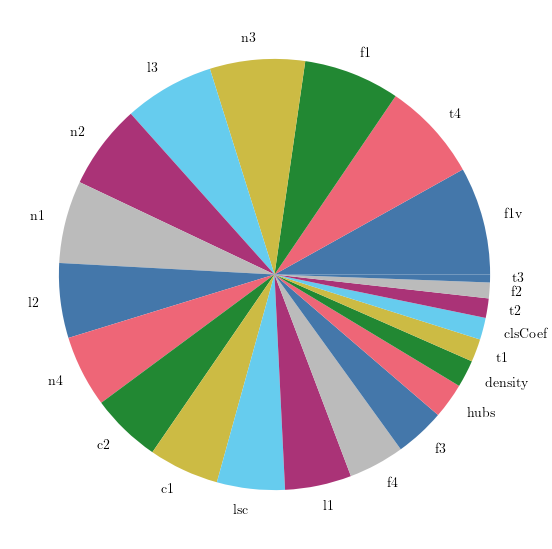

In [41]:
fig, ax = plt.subplots(1, 1,figsize=(15, 7))
summed_variances.rename(lambda it: it.split("-")[0]).sort_values(ascending=False).plot(kind='pie', ax=ax)
fig.savefig('../figures/quad/complexity-weighted.pdf')

In [42]:
summed_variances = summed_variances.sort_values(ascending=False)[:6].rename(lambda it: it.split("-")[0])
summed_variances

variable
f1v    0.242916
t4     0.222313
f1     0.216348
n3     0.213752
l3     0.202985
n2     0.190401
dtype: float64

In [43]:
COMPLEXITIES_WITH_HIGHEST_VARIANCE =summed_variances.index.tolist()

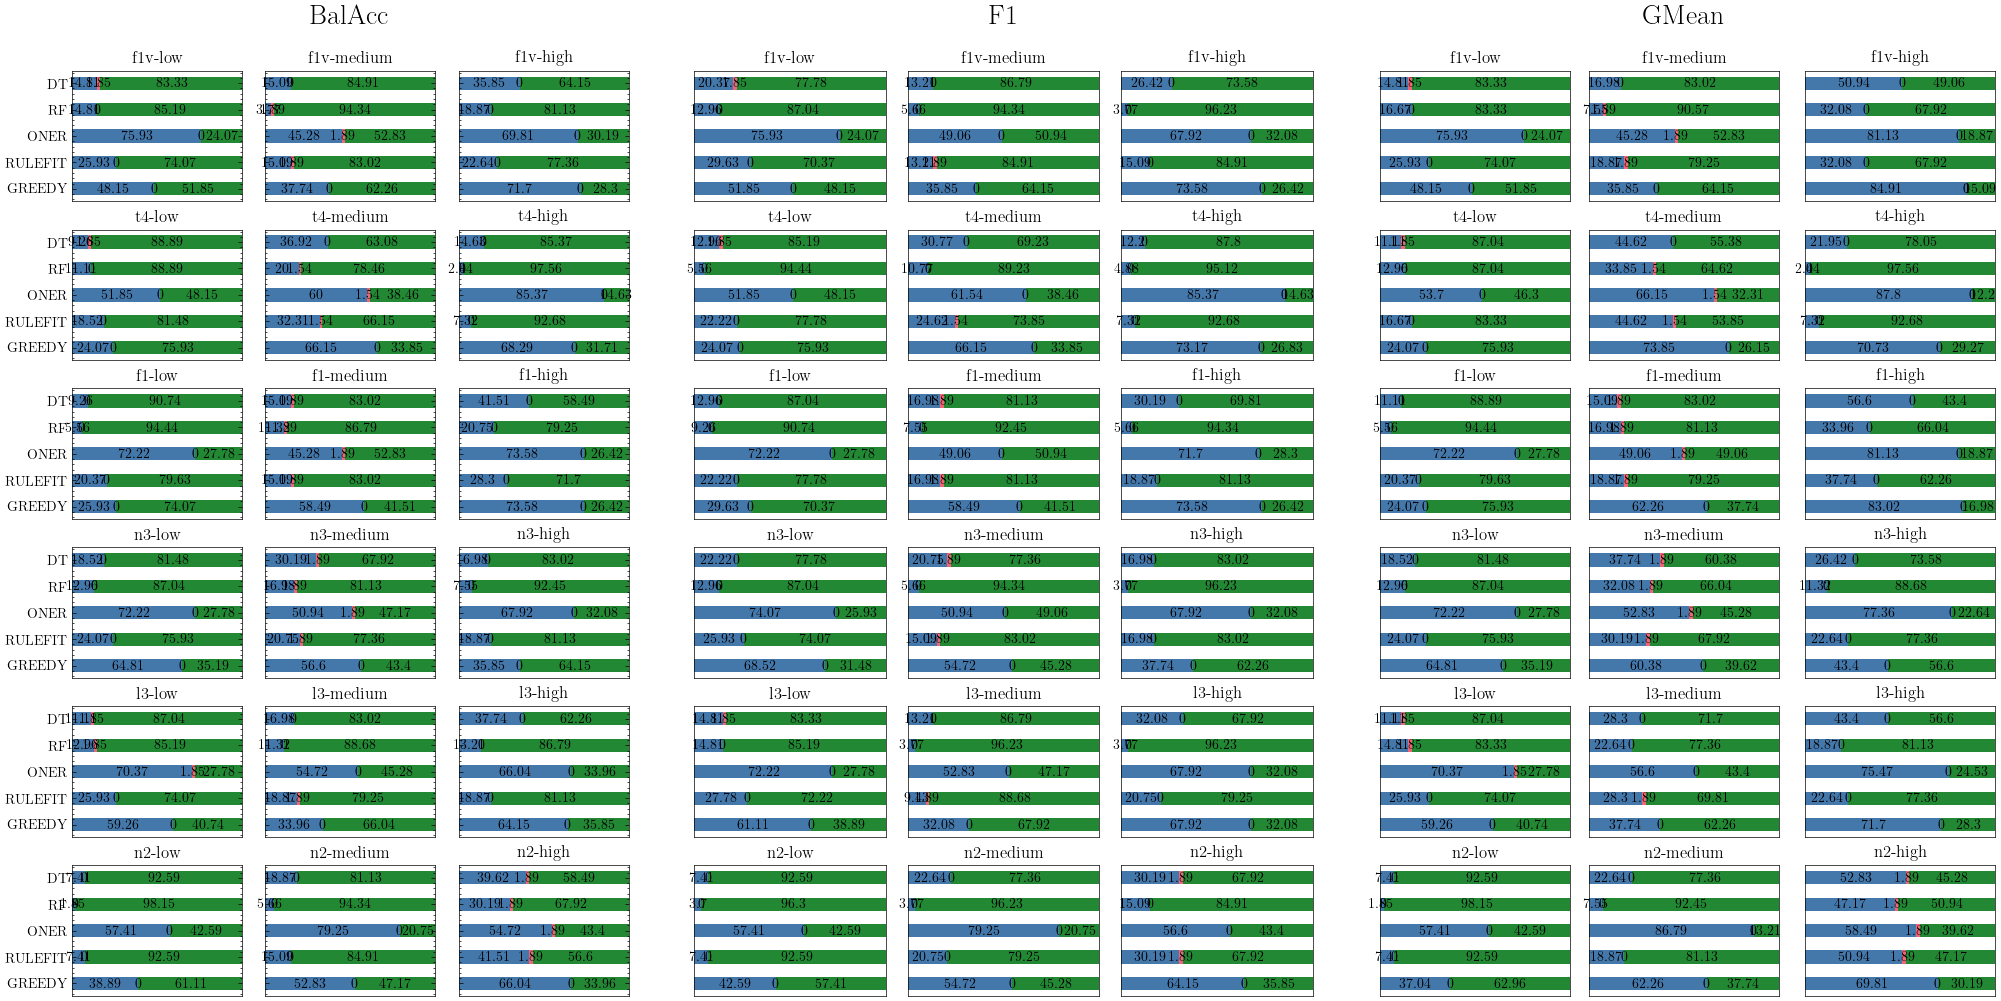

In [44]:
fig = plt.figure(layout='constrained', figsize=(20, 10))
subfigs = fig.subfigures(1, 3, wspace=0.07)


for labels, subfig in zip([ACC_LABELS, F1_LABELS, GMEAN_LABELS], subfigs):
    axes = subfig.subplots(len(COMPLEXITIES_TO_CONSIDER), 3, sharey="row")
    axes = axes.reshape(-1)
    
    axes_iter = iter(axes)
    for complexity in COMPLEXITIES_WITH_HIGHEST_VARIANCE:
        plot_labels = [l.split('_')[-1].upper() for l in labels]
        
        
        for value in ['low', 'medium', 'high']:
    
            ax = next(axes_iter)
            vals_to_plot = {k:  vals_to_percentage(v.values()) for k,v in make_sure_all_labels_are_there(quad_split_df.query(LIMITING_QUERY).query(f"`{complexity}-discretized` == '{value}'")[labels].apply(pd.Series.value_counts)).fillna(0).to_dict().items()}
    
            data = np.array(list(vals_to_plot.values()))
            data_cum = data.cumsum(axis=1)
            ax.invert_yaxis()
            ax.xaxis.set_visible(False)
            # ax.yaxis.set_visible(False)
            ax.set_xlim(0, np.sum(data, axis=1).max())
        
            for i, colname in enumerate(['better', 'equal', 'worse']):
                widths = data[:, i]
                starts = data_cum[:, i] - widths
                rects = ax.barh(plot_labels, widths, left=starts, height=0.5, label=colname)
                ax.bar_label(rects, label_type='center')
        
            ax.set_title(f"{complexity}-{value}")


for subfig, title in zip(subfigs, ["BalAcc", "F1", "GMean"]):
    subfig.axes[1].annotate(title, (0.5, 1), xytext=(0, 30),
                   textcoords='offset points', xycoords='axes fraction',
                   ha='center', va='bottom', size=20)

for subfig in subfigs[1:]:
    for ax in subfig.axes:
        ax.yaxis.set_visible(False)

fig.savefig('../figures/quad/metrics-with-high-variance-barplot.pdf')

## Models complexity

In [45]:
MODEL_COMPLEXITY_LABELS = ['complexity',"complexity_rf", "complexity_dt", 'complexity_rulefit', "complexity_oner"]
MODEL_COMPLEXITY_LABELS_WO_RF = ['complexity', "complexity_dt", 'complexity_rulefit', "complexity_oner"]


In [46]:
quad_split_df.query(LIMITING_QUERY)[MODEL_COMPLEXITY_LABELS]

,complexity,complexity_rf,complexity_dt,complexity_rulefit,complexity_oner
960,265.0,233,3.0,31,2
961,262.0,204,3.0,35,6
962,271.0,400,5.0,35,2
963,246.0,423,8.0,41,2
964,33.0,195,9.0,19,3
...,...,...,...,...,...
1115,185.0,470,19.0,48,4
1116,238.0,492,15.0,60,5
1117,250.0,541,16.0,56,6
1118,153.0,156,3.0,22,2


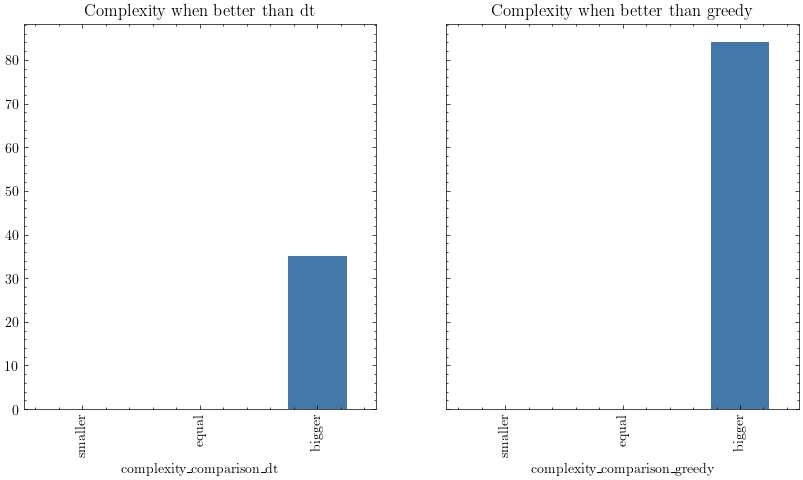

In [64]:
fig, axes = plt.subplots(1,2, sharey=True, figsize=(10, 5))
axes = axes.reshape(-1)
axes_iter = iter(axes)

for clf in ["dt", "greedy"]:
    ax = next(axes_iter)
    ax.set_title(f"Complexity when better than {clf}")
    
    data = quad_split_df\
        .query(LIMITING_QUERY)\
        .query(f"`test_balanced_accuracy_comparison_{clf}` == 'better'")\
        [f'complexity_comparison_{clf}'].value_counts().reindex(["smaller", "equal", "bigger"]).plot(kind='bar', ax=ax)

    

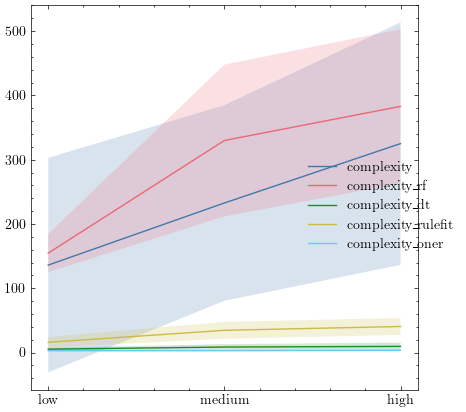

In [69]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))

means = quad_split_df\
    .query(LIMITING_QUERY)\
    .groupby("overall-complexity")[MODEL_COMPLEXITY_LABELS].mean().reindex(["low", "medium", "high"])

stds = quad_split_df\
    .query(LIMITING_QUERY)\
    .groupby("overall-complexity")[MODEL_COMPLEXITY_LABELS].std().reindex(["low", "medium", "high"])

ax.plot(means.index, means)

for model_complexity in MODEL_COMPLEXITY_LABELS:
    ax.fill_between(stds.index, means[model_complexity] - 1 * stds[model_complexity], means[model_complexity] + 1 * stds[model_complexity], alpha=0.2)
fig.legend(means.columns, loc='center right')
fig.savefig("../figures/quad/model-complexity-change-overall.pdf")

In [49]:
len(COMPLEXITY_METRICS)

22

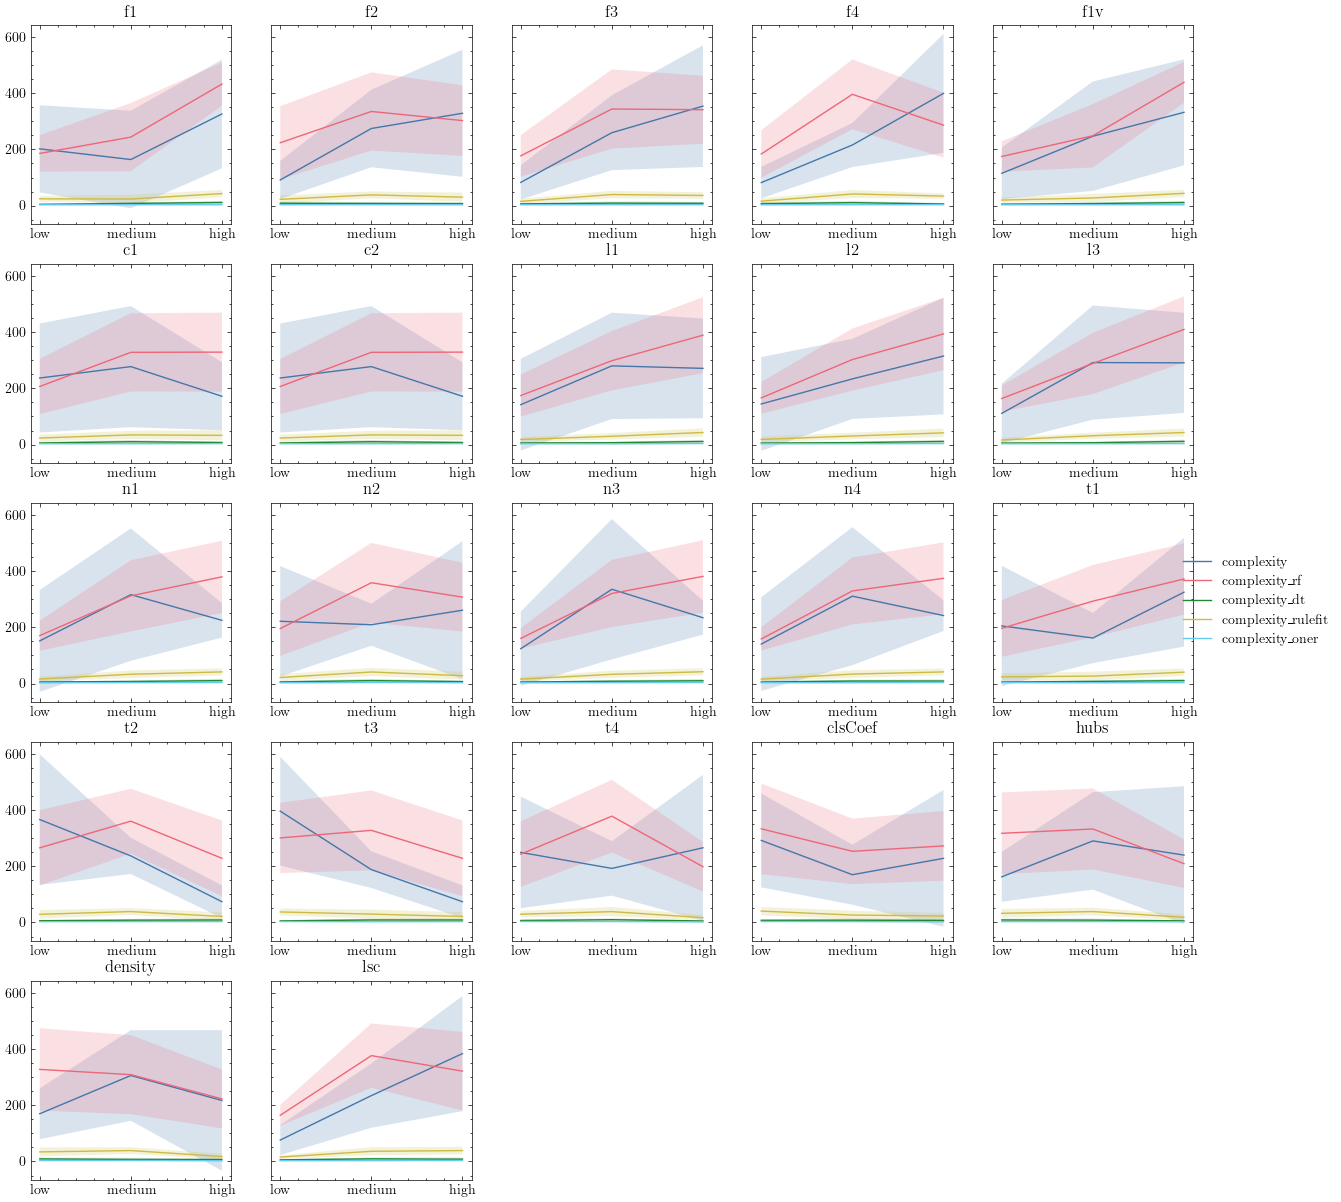

In [50]:
fig, axes = plt.subplots(5,5, sharey=True, figsize=(15, 15))
axes = axes.reshape(-1)
axes_iter = iter(axes)
for complexity in COMPLEXITY_METRICS:
    plot_labels = [l.split('_')[-1].upper() for l in labels]

    ax = next(axes_iter)
    ax.set_title(complexity)
    means = quad_split_df\
        .query(LIMITING_QUERY)\
        .groupby(f"{complexity}-discretized")[MODEL_COMPLEXITY_LABELS].mean().reindex(["low", "medium", "high"])

    stds = quad_split_df\
        .query(LIMITING_QUERY)\
        .groupby(f"{complexity}-discretized")[MODEL_COMPLEXITY_LABELS].std().reindex(["low", "medium", "high"])
    
    ax.plot(means.index, means)

    for model_complexity in MODEL_COMPLEXITY_LABELS:
        ax.fill_between(stds.index, means[model_complexity] - 1 * stds[model_complexity], means[model_complexity] + 1 * stds[model_complexity], alpha=0.2)

# handles, labels = axes[0].get_legend_handles_labels()
fig.legend(means.columns, loc='center right')
fig.delaxes(axes[-1])
fig.delaxes(axes[-2])
fig.delaxes(axes[-3])

fig.savefig("../figures/quad/model-complexity-change-per-metric.pdf")

In [51]:
labels

['test_geometric_mean_comparison_dt',
 'test_geometric_mean_comparison_rf',
 'test_geometric_mean_comparison_oner',
 'test_geometric_mean_comparison_rulefit',
 'test_geometric_mean_comparison_greedy']

<Axes: >

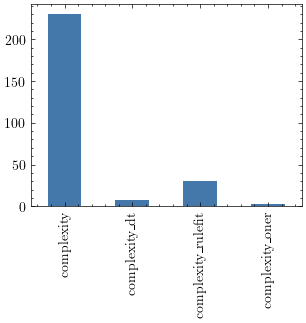

In [52]:
quad_split_df.query(LIMITING_QUERY)[MODEL_COMPLEXITY_LABELS_WO_RF].mean().plot(kind='bar')